In [42]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader

import pandas as pd
import numpy as np

import math
import ot

import matplotlib.pyplot as plt

In [43]:
dataset = get_dataset(dataset="poverty", download=True)

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Neural Net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(8, 48, 3)
        self.conv2 = nn.Conv2d(48, 96, 3)
        self.conv3 = nn.Conv2d(96, 1, 1)
        
        self.fc1 = nn.Linear(2916, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x, meta):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
    
    
    
    
    
    
class dataIterable:
    def __init__(self, dataset, indicies, batch_size=1):
        
        self.dataset = dataset
        self.indicies = indicies
        self.i = 0
        self.bs = batch_size
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.i < len(self.indicies):
            
            i = self.i
            self.i += self.bs
            return (torch.stack([dataset[d][q] for d in range(i, min(i+self.bs, len(self.indicies)))]) for q in range(3))
            
        else:
            raise StopIteration

In [45]:
urban_net = torch.load('../models/urban/CNN_epoch_317')

In [105]:
# target country
T_country = 'nigeria'

# set train, valid proportions
# test is the rest
train_p, valid_p = .7, .2

meta = pd.read_csv('./data/poverty_v1.1/dhs_metadata.csv')

T = meta[meta['country'] == T_country]

# Urban and rural split
T_u = T[T['urban'] == True]
T_r = T[T['urban'] == False]


def tvt_split_index(ids, train_p, valid_p, random_seed=42):
    np.random.seed(random_seed)
    n = len(ids)
    np.random.shuffle(ids)
    train = ids[:int(n*train_p)]
    valid = ids[int(n*train_p):int(n*(train_p+valid_p))]
    test = ids[int(n*(train_p+valid_p)):]
    return train, valid, test

T_u_i = T_u.index.values
T_r_i = T_r.index.values

# train, valid, test, indicies
T_u_i_train, T_u_i_valid, T_u_i_test = tvt_split_index(T_u_i, train_p, valid_p)
T_r_i_train, T_r_i_valid, T_r_i_test = tvt_split_index(T_r_i, train_p, valid_p)

In [106]:
# source country
S_country = 'mali'

meta = pd.read_csv('./data/poverty_v1.1/dhs_metadata.csv')
S = meta[meta['country'] == S_country]

# Urban and rural split
S_u = S[S['urban'] == True]
S_r = S[S['urban'] == False]

# indicies
S_u_i = S_u.index.values
S_r_i = S_r.index.values

In [48]:
u_low_cutoff = 1.04
u_high_cutoff = 1.45

In [49]:
# evaluate without transport

actual = np.array([])
predicted = np.array([])
with torch.no_grad():
    for images, labels, metadata in dataIterable(dataset, S_u_i, batch_size=64):
        
        # classification labels based off on cutoff values
        labels = torch.where(labels < u_low_cutoff, 0, torch.where(labels > u_high_cutoff, 2, 1)).flatten()
        
        if torch.cuda.is_available():
                images, labels, meta = images.cuda(), labels.cuda(), metadata.cuda()
        
        outputs = urban_net(images, meta)

        actual = np.append(actual, labels.cpu())
        predicted = np.append(predicted, outputs.argmax(dim=1).cpu())
        

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [50]:
res_S_u_wo_transport = pd.DataFrame({'actual': actual, 'predicted': predicted}).astype(int).reset_index()
res_S_u_wo_transport

,index,actual,predicted
0,0,0,0
1,1,0,0
2,2,0,0
3,3,1,2
4,4,2,2
...,...,...,...
433,433,0,0
434,434,0,0
435,435,0,1
436,436,1,0


In [51]:
cm_S_u_wo_transport = res_S_u_wo_transport.pivot_table(values='index', index='actual', columns='predicted', aggfunc='count')

In [52]:
import ot

In [107]:
import math
def get_pixel_sample(data_iterable, n_samples, random_seed=34):
    np.random.seed(random_seed)
    n_images = len(data_iterable.indicies)
    batch_size = data_iterable.bs
    
    n_batches = math.ceil(n_images/batch_size)
    
    n_samples_per_batch = math.ceil(n_samples/n_batches)
    
    assert n_samples_per_batch > 0
    
    
    samples = torch.tensor([])
    for images, _, _ in data_iterable:
        b = torch.transpose(images, 0, 1).flatten(start_dim=1, end_dim=3)
        ids = np.random.randint(low=0, high=b.shape[1], size=n_samples_per_batch)
        samples = torch.cat((samples, b[:, ids]), dim=1)
    
    # remove extra samples
    ids = np.random.randint(low=0, high=samples.shape[1], size=n_samples)
    samples = samples[:, ids]
        
    return samples

In [108]:
pxls = get_pixel_sample(dataIterable(dataset, S_u_i, 10), 500)
Xs = pxls.T

In [109]:
sdf = pd.DataFrame(Xs)

''

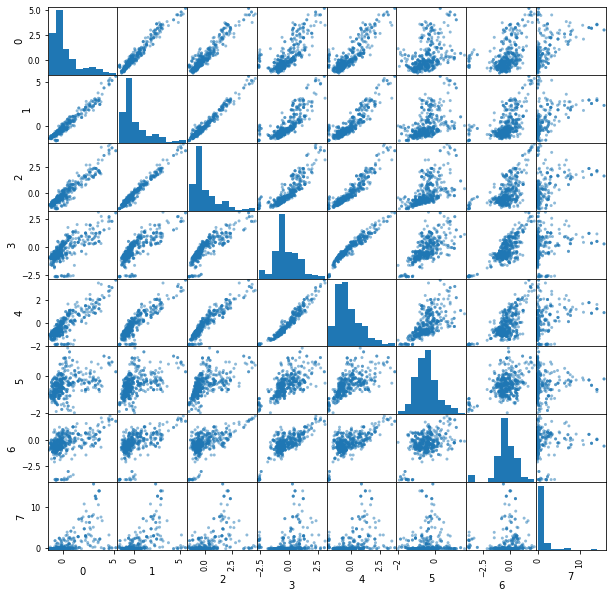

In [110]:
pd.plotting.scatter_matrix(sdf, figsize=(10, 10))
""

In [111]:
pxls = get_pixel_sample(dataIterable(dataset, T_u_i, 10), 500)
Xt = pxls.T

In [112]:
tdf = pd.DataFrame(Xt)

''

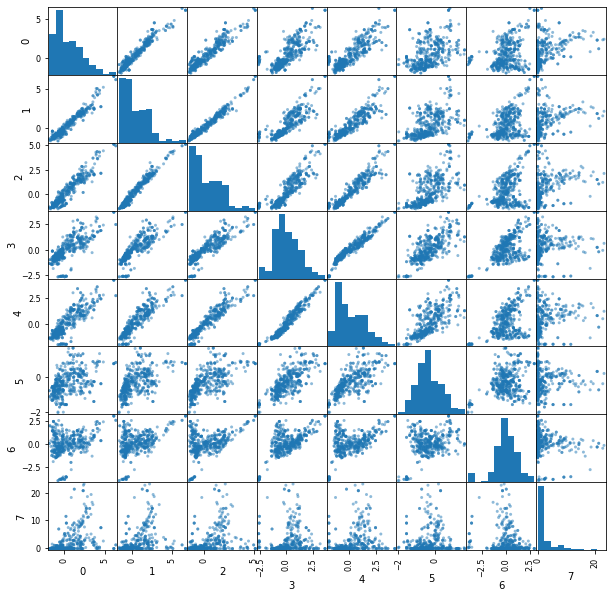

In [113]:
pd.plotting.scatter_matrix(tdf, figsize=(10, 10))
""

In [115]:
sdf

,0,1,2,3,4,5,6,7
0,-0.686251,-0.914962,-0.751972,-0.398100,-0.458650,-0.936689,-0.853340,-0.173862
1,-0.053782,-0.478952,-0.537234,-0.780738,-0.822657,-0.599500,-0.798230,0.006192
2,-0.627366,-0.900847,-0.693672,-0.815625,-0.811244,-0.483230,-0.230173,-0.173862
3,-0.714603,-0.861637,-0.884119,-0.953487,-1.049712,-0.541365,-0.707510,-0.173862
4,0.026913,-0.304862,-0.408974,-0.263052,-0.426213,0.098125,-0.216607,-0.173862
...,...,...,...,...,...,...,...,...
495,-0.219532,-0.384849,-0.570271,-0.698583,-0.723546,-0.773907,-0.529463,-0.173862
496,4.471648,5.051161,4.559155,2.298367,2.769966,0.749239,2.044597,0.600390
497,0.942903,0.532654,0.448035,-0.028968,-0.006343,0.888765,-0.896580,-0.173862
498,-0.182457,-0.508752,-0.603307,-0.560158,-0.761989,-0.366959,-0.696488,-0.173862


In [58]:
Xt.shape, Xs.shape

(torch.Size([500, 8]), torch.Size([500, 8]))

In [59]:
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)

/home/llloyd/.local/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


In [60]:
tXs = ot_sinkhorn.transform(Xs)

In [64]:
tsdf = pd.DataFrame(tXs)

In [65]:
tsdf

,0,1,2,3,4,5,6,7
0,-1.121300,-0.940811,-1.162324,-0.736361,-1.046622,-0.979244,0.902017,-0.178800
1,-1.256484,-1.261905,-1.170483,-1.127631,-1.134949,-0.793026,-0.795792,-0.212089
2,2.452102,1.939493,1.488692,0.470152,0.555291,-0.529737,0.133555,7.584461
3,0.797803,0.906374,0.891575,0.618992,0.738935,-0.481732,0.007664,1.565869
4,2.281830,2.405250,1.773423,1.149742,1.182495,-0.190729,0.530377,9.066449
...,...,...,...,...,...,...,...,...
495,1.933040,1.608558,1.207877,0.109457,0.482606,-0.832030,-0.369219,3.594414
496,0.842580,0.262892,-0.267111,-1.823987,-1.294185,-0.715771,-2.778797,18.207890
497,-1.042913,-0.873714,-1.102856,-0.548771,-0.904012,-0.839622,1.342889,-0.088382
498,2.452102,1.939493,1.488692,0.470152,0.555291,-0.529737,0.133555,7.584461


''

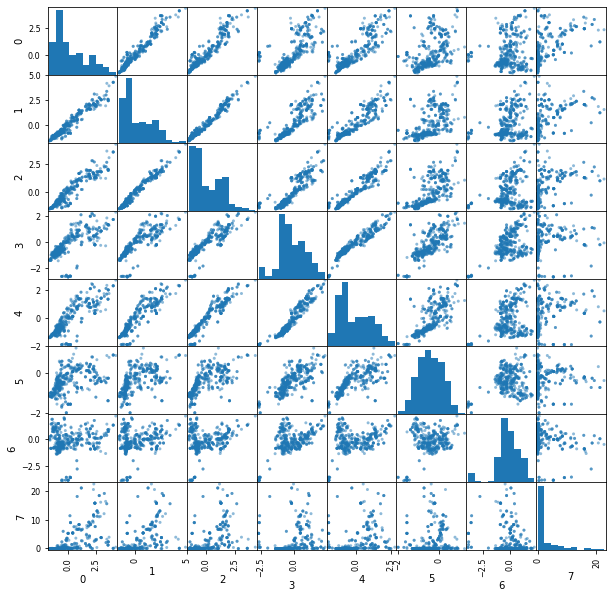

In [66]:
pd.plotting.scatter_matrix(tsdf, figsize=(10, 10))
""

In [152]:
# evaluate with transport


def transport_images(images):
    shape = images.shape
    for batch in range(shape[0]):
        for row in range(shape[2]):
            images[batch, :, row, :] = ot_sinkhorn.transform(images[batch, :, row, :].T).T
                
                  
# Loss Function
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

running_loss = 0.0
batches = 0
actual = np.array([])
predicted = np.array([])
with torch.no_grad():
    for images, labels, metadata in dataIterable(dataset, S_u_i, batch_size=64):
        
        # classification labels based off on cutoff values
        labels = torch.where(labels < u_low_cutoff, 0, torch.where(labels > u_high_cutoff, 2, 1)).flatten()
        
        transport_images(images)
        
        if torch.cuda.is_available():
                images, labels, meta = images.cuda(), labels.cuda(), metadata.cuda()
        
        outputs = urban_net(images, meta)
        
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        batches += 1
        
        actual = np.append(actual, labels.cpu())
        predicted = np.append(predicted, outputs.argmax(dim=1).cpu())
        
loss = running_loss/batches
acc = correct/count

In [94]:
acc

0.95662100456621

In [99]:
images = images.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


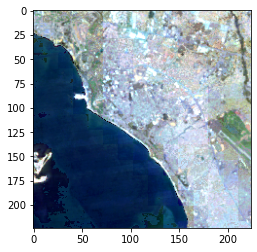

In [117]:
a = 9
plt.imshow((torch.stack([images[a][2], images[a][1], images[a][0]], dim=2)+1.2290)/(2.6758+1.2290))

In [103]:
def show_image(id):
    # definitely not accurate...
    plt.imshow((torch.stack([dataset[id][0][2], dataset[id][0][1], dataset[id][0][0]], dim=2)+1.2290)/(2.6758+1.2290))
    
    print(f'wealth index: {dataset[id][1][0]}')

In [104]:
def show_channels(id, figsize=(12, 6)):
    fig, axs = plt.subplots(2, 4, figsize=figsize)

    for i in range(8):
        axs[i//4][i%4].imshow(dataset[id][0][i])
    
    print(f'wealth index: {dataset[id][1][0]}')

In [12]:
atn = pd.read_csv('../results/angola_to_nigeria.csv')

In [22]:
atn[atn['urban']==False].pivot_table(index='predicted', columns='actual', values='urban', aggfunc='count').fillna(0).astype(int)

actual,0,1,2
predicted,,,
0,341,34,20
1,0,44,4
2,5,6,380


In [23]:
mtn = pd.read_csv('../results/mali_to_nigeria.csv')

In [31]:
mtn[mtn['urban']==False][mtn['transport']==False].pivot_table(index='predicted', columns='actual', values='urban', aggfunc='count').fillna(0).astype(int)

/tmp/ipykernel_34260/2737608354.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mtn[mtn['urban']==False][mtn['transport']==False].pivot_table(index='predicted', columns='actual', values='urban', aggfunc='count').fillna(0).astype(int)


actual,0,1,2
predicted,,,
0,170,16,9
1,0,22,2
2,3,4,191


In [32]:
mtn[mtn['urban']==False][mtn['transport']==True].pivot_table(index='predicted', columns='actual', values='urban', aggfunc='count').fillna(0).astype(int)

/tmp/ipykernel_34260/2340951490.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mtn[mtn['urban']==False][mtn['transport']==True].pivot_table(index='predicted', columns='actual', values='urban', aggfunc='count').fillna(0).astype(int)


actual,0,1,2
predicted,,,
0,171,18,11
1,0,22,2
2,2,2,189


In [37]:
v = mtn[mtn['urban']==False].pivot_table(index='id', columns='transport', values=['predicted', 'actual'], aggfunc=sum)

In [40]:
v[v['predicted'][False] != v['predicted'][True]]

actual      predicted     
transport  False True     False True
id                                  
77             2    2         2    0
79             0    0         2    0
258            2    2         2    0
315            1    1         2    0
319            1    1         2    0

In [11]:
meta

,lat,lon,wealthpooled,country,year,urban,nl_mean,nl_center,households
0,-11.915085,22.876839,-1.019361,angola,2011,False,-0.086633,0.016189,37
1,-11.886975,22.924997,-1.090052,angola,2011,False,-0.097684,-0.173862,37
2,-9.498591,17.830034,-1.143002,angola,2011,False,-0.141589,-0.173862,37
3,-8.864000,13.240764,1.056769,angola,2011,True,15.228898,14.859587,32
4,-8.874110,13.197329,1.454064,angola,2011,True,11.082343,13.063629,33
...,...,...,...,...,...,...,...,...,...
19664,-18.032501,31.082756,1.159348,zimbabwe,2015,True,1.005626,2.186287,25
19665,-18.031948,31.095280,1.268232,zimbabwe,2015,True,0.895127,0.840323,24
19666,-18.021593,31.084930,1.506693,zimbabwe,2015,True,1.183905,2.194796,26
19667,-17.989489,31.033354,1.882921,zimbabwe,2015,True,0.515834,1.890566,26


In [83]:
torch.save(ot_sinkhorn, '../results/test.pt')

TypeError: cannot pickle 'torch._C.Generator' object

In [68]:
type(ot_sinkhorn.coupling_)

torch.Tensor

In [70]:
ot_sinkhorn.coupling_.shape

torch.Size([500, 500])

In [72]:
ot_sinkhorn.log_

{}

In [74]:
qqq = ot.da.SinkhornTransport()

In [81]:
qqq.coupling_ = torch.load('../results/test.pt')
qqq.log_ = dict()
qqq.xs_ = torch.tensor([])
qqq.xt_ = torch.tensor([])
qqq.nx = qqq._get_backend(qqq.xs_, None, qqq.xt_, None)

In [82]:
qqq.transform(Xs)

RuntimeError: einsum(): the number of subscripts in the equation (2) does not match the number of dimensions (1) for operand 0 and no ellipsis was given

In [96]:
def save_sinkhorn(sinkhorn, path):
    try:
        os.mkdir(path)
    except FileExistsError:
        print(f'Overwriting {path}')
    finally:
        torch.save(sinkhorn.coupling_, os.path.join(path, 'coupling.pt'))
        torch.save(sinkhorn.xt_, os.path.join(path, 'xt.pt'))
        torch.save(sinkhorn.xs_, os.path.join(path, 'xs.pt'))

In [97]:
def load_sinkhorn(path):
    sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
    sinkhorn.coupling_ = torch.load(os.path.join(path, 'coupling.pt'))
    sinkhorn.xt_ = torch.load(os.path.join(path, 'xt.pt'))
    sinkhorn.xs_ = torch.load(os.path.join(path, 'xs.pt'))
    sinkhorn.nx = sinkhorn._get_backend(sinkhorn.xs_, None, sinkhorn.xt_, None)
    return sinkhorn

In [98]:
save_sinkhorn(ot_sinkhorn, '../results/test/')

Overwriting ../results/test/


In [88]:
import os

In [100]:
qqq = load_sinkhorn('../results/test/')

In [101]:
qqq.transform(Xs)

tensor([[-1.1213, -0.9408, -1.1623,  ..., -0.9792,  0.9020, -0.1788],
        [-1.2565, -1.2619, -1.1705,  ..., -0.7930, -0.7958, -0.2121],
        [ 2.4521,  1.9395,  1.4887,  ..., -0.5297,  0.1336,  7.5845],
        ...,
        [-1.0429, -0.8737, -1.1029,  ..., -0.8396,  1.3429, -0.0884],
        [ 2.4521,  1.9395,  1.4887,  ..., -0.5297,  0.1336,  7.5845],
        [-0.2960, -0.2750, -0.8372,  ..., -1.1018,  1.9045, -0.0443]])